In [1]:
import openl3

In [2]:
import openmic.vggish

In [3]:
import librosa

In [44]:
from tqdm.notebook import tqdm

In [5]:
import soundfile as sf

In [6]:
import numpy as np

In [7]:
import os

---
# OpenL3 model

In [9]:
model = openl3.models.load_embedding_model(input_repr="mel128", content_type="music", embedding_size=512)

tracking <tf.Variable 'melspectrogram_1/real_kernels:0' shape=(2048, 1, 1, 1025) dtype=float32> dft_real_kernels
tracking <tf.Variable 'melspectrogram_1/imag_kernels:0' shape=(2048, 1, 1, 1025) dtype=float32> dft_imag_kernels
tracking <tf.Variable 'melspectrogram_1/Variable:0' shape=(1025, 128) dtype=float32> freq2mel



In [32]:
irmas_files = librosa.util.find_files('/home/bmcfee/data/irmas/IRMAS-TrainingData/')

In [33]:
outpath = '/home/bmcfee/working/wimir2019/irmas-openl3'

In [34]:
!mkdir -p {outpath}

In [35]:
for fn in tqdm(irmas_files):
    openl3.process_file(fn, output_dir=outpath, model=model, verbose=False)

In [40]:
openmic_files = librosa.util.find_files('/home/bmcfee/data/openmic-2018/audio/')

In [41]:
outpath = '/home/bmcfee/working/wimir2019/openmic-openl3'

In [42]:
!mkdir -p {outpath}

In [43]:
for fn in tqdm(openmic_files):
    prefix = os.path.basename(fn)[:3]
    
    dirname = os.path.sep.join([outpath, prefix])
    try:
        os.mkdir(dirname)
    except OSError:
        pass
    
    openl3.process_file(fn, output_dir=dirname, model=model, verbose=False)

---
# VGGish model

In [44]:
import numpy as np
import json

In [45]:
files = librosa.util.find_files('/home/bmcfee/data/irmas/vggish/', ext='npz')

In [58]:
!mkdir -p /home/bmcfee/working/wimir2019/irmas-vggish

In [61]:
for fn in tqdm(files):
    bn = os.path.basename(fn)
    base = os.path.splitext(os.path.splitext(bn)[0])[0]
    
    X = np.load(fn)
    
    out = dict(features=X['features_z'].tolist(), time_points=(0.96 * np.arange(len(X['features_z']))).tolist())
    with open('/home/bmcfee/working/wimir2019/irmas-vggish/{}.json'.format(base), 'w') as fd:
        json.dump(out, fd)

---
# YAMNet model

In [8]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

In [9]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [37]:
# Utility functions for loading audio files and making sure the sample rate is correct.

def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    wav, sr = librosa.load(filename, sr=16000, res_type='soxr_hq')
    return wav


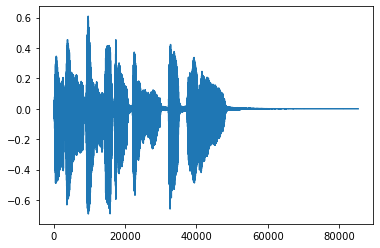

In [13]:
# Verify that the loader works
testing_wav_data = load_wav_16k_mono(librosa.ex('trumpet'))

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data,rate=16000)


In [45]:
irmas_files = librosa.util.find_files('/home/bmcfee/data/irmas/IRMAS-TrainingData/')

In [46]:
outpath = '/home/bmcfee/working/wimir2019/irmas-yamnet'

In [47]:
!mkdir -p {outpath}

In [48]:
for fn in tqdm(irmas_files):
    bn = os.path.basename(fn)
    dn = os.path.basename(os.path.dirname(fn))
    base = os.path.splitext(os.path.splitext(bn)[0])[0]
    
    wav = load_wav_16k_mono(fn)
    
    scores, embedding, specgram = yamnet_model(wav)
    
    outdir = f'{outpath}/{dn}'
    os.makedirs(outdir, exist_ok=True)
    
    np.savez(f'{outdir}/{base}.npz', X=embedding.numpy())

  0%|          | 0/6705 [00:00<?, ?it/s]

In [50]:
openmic_files = librosa.util.find_files('/home/bmcfee/data/openmic-2018/audio/')

In [51]:
outpath = '/home/bmcfee/working/wimir2019/openmic-yamnet'

In [52]:
!mkdir -p {outpath}

In [53]:
for fn in tqdm(openmic_files):
    bn = os.path.basename(fn)
    dn = os.path.basename(os.path.dirname(fn))
    base = os.path.splitext(os.path.splitext(bn)[0])[0]
    
    wav = load_wav_16k_mono(fn)
    
    scores, embedding, specgram = yamnet_model(wav)
    
    outdir = f'{outpath}/{dn}'
    os.makedirs(outdir, exist_ok=True)
    
    np.savez(f'{outdir}/{base}.npz', X=embedding.numpy())

  0%|          | 0/20000 [00:00<?, ?it/s]